# Liquid State Machine lab
author: Aliprandi Francesco

In [1]:
from data_prep import read_data, train_test_split
from lsm import LSM
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler


# utility function for plot the data
def plot_distances(y, y_pred, tspan, title):
    plt.figure(figsize=(10, 4))
    plt.plot(tspan[:y.shape[0]], y, label='True')
    plt.plot(tspan[:y_pred.shape[0]], y_pred, label='Predicted', linestyle='--', linewidth=0.5)
    plt.xlabel('Time')
    plt.ylabel('Solar Power')
    plt.title(title)
    plt.legend()
    plt.show()

### Data loading and visualization

In [2]:
path = "data/solar_data.csv"
u = read_data(path)

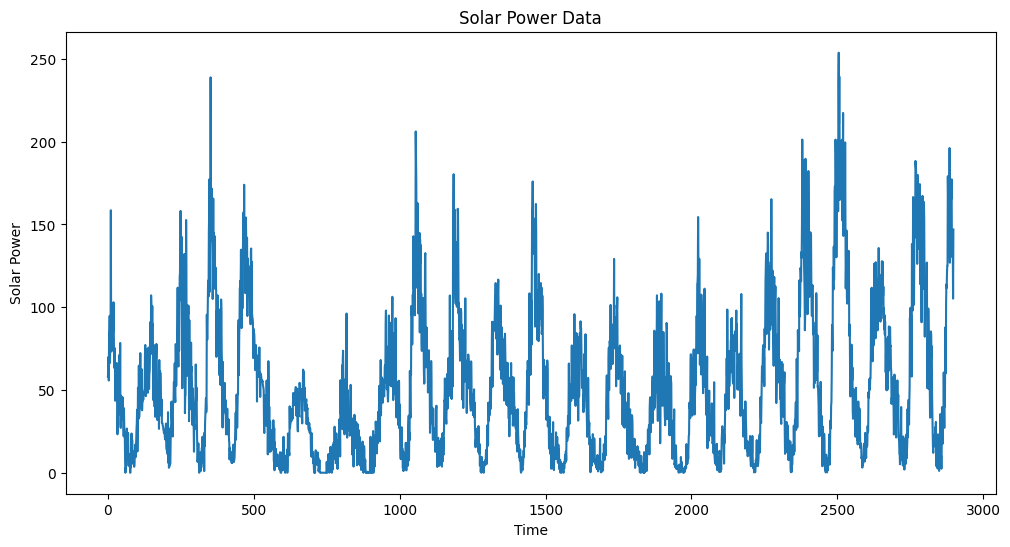

In [3]:
tspan = np.arange(0, u.size, 1) 

plt.figure(figsize=(12, 6))
plt.plot(tspan, u)
plt.xlabel('Time')
plt.ylabel('Solar Power')
plt.title('Solar Power Data')
plt.show()

### Data preparation

In [4]:
u_train, y_train, u_val, y_val, u_test, y_test = train_test_split(u)
print("input shapes (training/val,tes): ", u_train.shape, u_val.shape, u_test.shape)
print("output shapes (training/val,tes): ", y_train.shape, y_val.shape, y_test.shape)

input shapes (training/val,tes):  (1883,) (507,) (508,)
output shapes (training/val,tes):  (1883,) (507,) (508,)


In [5]:
def check_relationship(u, y):
    return np.all(u[1:] == y[:-1])

print("u_train and y_train relationship:", check_relationship(u_train, y_train))
print("u_val and y_val relationship:", check_relationship(u_val, y_val))
print("u_test and y_test relationship:", check_relationship(u_test, y_test))

u_train and y_train relationship: True
u_val and y_val relationship: True
u_test and y_test relationship: True


### Model grid search

In [6]:
from joblib import Parallel, delayed
from tqdm import tqdm  
from sklearn.preprocessing import QuantileTransformer

# Define the scaler

scaler = QuantileTransformer()
scaler.fit(u_train.reshape(-1, 1))

def single_experiment(i, redout, param_grid, u_train, y_train, u_val, y_val, seed=None):
    if seed is not None:
        np.random.seed(seed + i)  # Set the seed for reproducibility
    
    # Randomly sample the hyperparameters
    params = {k: np.random.choice(v) for k, v in param_grid.items()}
    lambda_reg, lr, batch_size, n_epochs = None, None, None, None

    if redout == "linear":
        lambda_reg = params.pop('lambda_reg', 0.01) 

    elif redout == "mlp":
        lr = float(params.pop('lr', 0.001))
        batch_size = int(params.pop('batch_size', 64))
        n_epochs = int(params.pop('n_epochs', 20))

    # Initialize and train the model
    lsm = LSM(scaler=scaler, **params)
    lsm.fit(u_train, y_train, lambda_reg, lr, batch_size, n_epochs)

    # Model evaluation
    val_pred = lsm.predict(u_val)
    val_mae = lsm.evaluate(y_val, val_pred)

    return {
        'iteration': i,
        'params': {**params, 'lambda_reg': lambda_reg, 'lr': lr, 'batch_size': batch_size, 'n_epochs': n_epochs},
        'model': lsm,
        'mae': val_mae
    }

def parallel_random_grid_search(n, redout, param_grid, u_train, y_train, u_val, y_val, seed=None, n_jobs=-1):
    # Run the experiments in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(single_experiment)(i, redout, param_grid, u_train, y_train, u_val, y_val, seed)
        for i in tqdm(range(n), desc="Random Grid Search Progress")
    )

    # Find best result
    best_result = min(results, key=lambda x: x['mae'])
    best_params = best_result['params']
    best_model = best_result['model']
    best_mae = best_result['mae']

    print(f"Best validation loss: {best_mae:.4f} \t params: {best_params}")
    return best_params, best_model, best_mae

linear_param_grid = {
    'n': [50, 100, 200, 300, 400],
    'alpha': [0.6, 0.7, 0.8, 0.9],
    'Win_e': [3, 4, 4.5, 5, 6],
    'Win_i': [0.5, 1, 2, 3, 3.5],
    'W_e':   [0.3 ,0.5, 0.6],
    'W_i':   [0.5, 0.7, 1],
    'lambda_reg': [0, 0.001, 0.01, 0.05, 0.1],
    'redout': ['linear'],
}

mlp_param_grid = {
    'n': [50, 100, 200, 300, 400],
    'alpha': [0.6, 0.7, 0.8, 0.9],
    'Win_e': [3, 4, 4.5, 5, 6],
    'Win_i': [0.5, 1, 2, 3, 3.5],
    'W_e':   [0.3 ,0.5, 0.6],
    'W_i':   [0.5, 0.7, 1, 1],
    'hidden_size': [64, 128, 256, 512],
    'lr': [0.001, 0.005, 0.01, 0.05, 0.1, 0.3],
    'batch_size': [32, 64, 128, 256],
    'n_epochs': [10, 20, 30, 40, 50],
    'redout': ['mlp']
    
}

best_params, best_model, best_mae = parallel_random_grid_search(1000, "linear", linear_param_grid, u_train, y_train, u_val, y_val, seed=42)
#best_params, best_model, best_mae = parallel_random_grid_search(1000, "mlp", mlp_param_grid, u_train, y_train, u_val, y_val, seed=42)
    

Random Grid Search Progress: 100%|██████████| 1000/1000 [01:20<00:00, 12.49it/s]


Best validation loss: 19.7294 	 params: {'n': np.int64(50), 'alpha': np.float64(0.7), 'Win_e': np.float64(6.0), 'Win_i': np.float64(1.0), 'W_e': np.float64(0.6), 'W_i': np.float64(1.0), 'redout': np.str_('linear'), 'lambda_reg': np.float64(0.05), 'lr': None, 'batch_size': None, 'n_epochs': None}


Validation MAE:  20.753170013427734


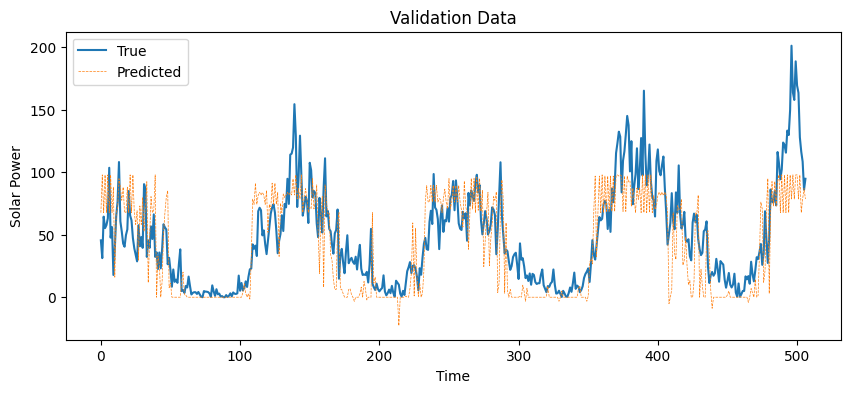

In [7]:
val_pred = best_model.predict(u_val)
print("Validation MAE: ", best_model.evaluate(y_val, val_pred))

plot_distances(y_val, val_pred, tspan, 'Validation Data')


### Retrain the model

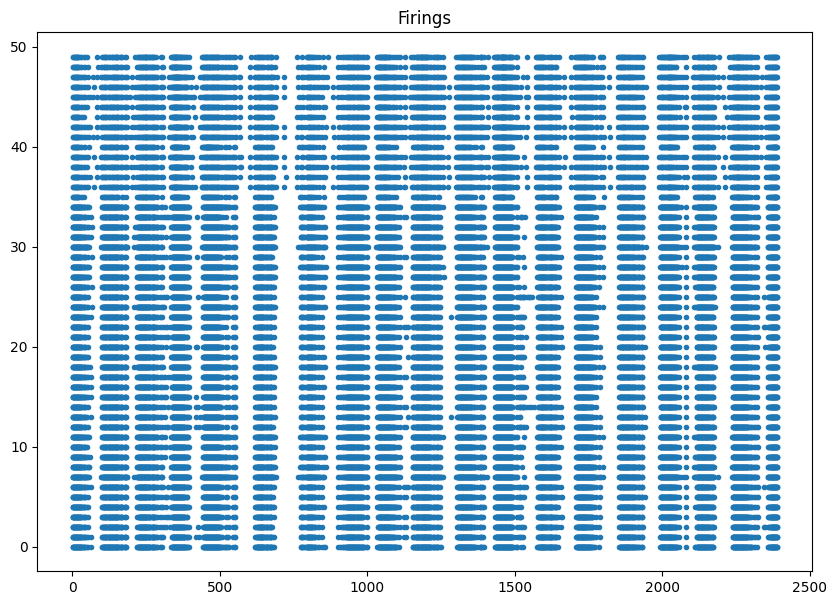

In [8]:
u_retrain = np.append(u_train, u_val)
y_retrain = np.append(y_train, y_val)

if best_params['redout'] == 'linear':
    lambda_reg = best_params['lambda_reg']
    best_model.fit(u_retrain, y_retrain, lambda_reg, verbose=True)
elif best_params['redout'] == 'mlp':
    lr = float(best_params['lr'])
    batch_size = int(best_params['batch_size'])
    n_epochs = int(best_params['n_epochs'])
    best_model.fit(u_retrain, y_retrain, 0, lr, n_epochs, batch_size, verbose=True)

retrain_pred = best_model.predict(u_retrain)

Training MAE: 23.8634


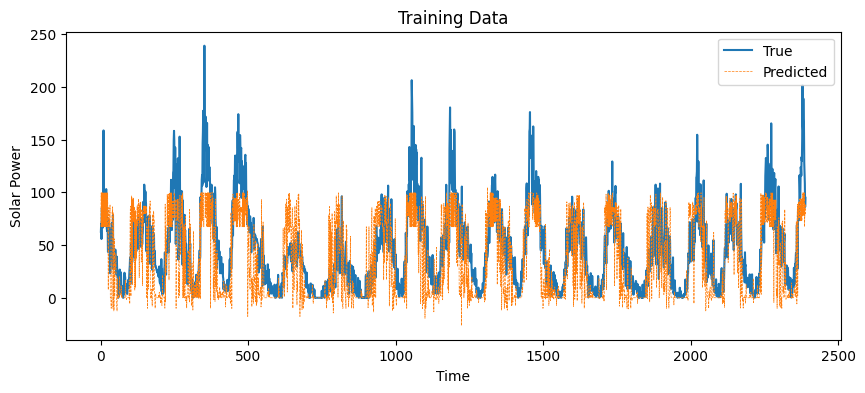

In [9]:
print(f'Training MAE: {best_model.evaluate(y_retrain, retrain_pred):.4f}')

plot_distances(y_retrain, retrain_pred, tspan, 'Training Data')

Test MAE: 35.4870


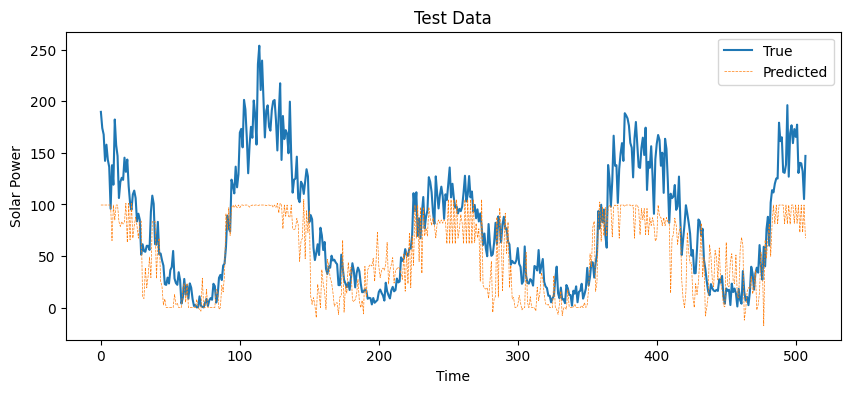

In [10]:
test_pred = best_model.predict(u_test)
print(f'Test MAE: {best_model.evaluate(y_test, test_pred):.4f}')

plot_distances(y_test, test_pred, tspan, 'Test Data')

### Full time series prediction

Full Time Series MAE: 27.6702


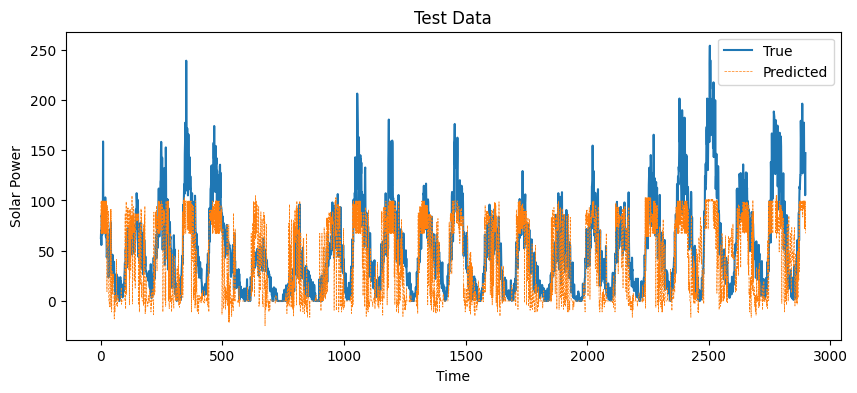

In [11]:
u_full = np.concatenate((u_train, u_val, u_test))
y_full = np.concatenate((y_train, y_val, y_test))

full_pred = best_model.predict(u_full)
print(f'Full Time Series MAE: {best_model.evaluate(y_full, full_pred):.4f}')

plot_distances(y_full, full_pred, tspan, 'Test Data')